# PRISCILA DENISE MUWANGUZI
Reg No: M23B23/010

Access No: B20237

---

# **BIG DATA TAKE HOME EXAM**


---
SENTIMENT ANALYSIS ON TWEET TEXT


# **JUSTIFICATION FOR BIGDATA**
The dataset consists of over one million unstructured social media posts characterized by
high volume and high velocity. Processing such data requires distributed computation
and storage. Traditional relational databases are inefficient for large-scale text analytics,
making Apache Spark a suitable Big Data platform for this project.

In [60]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Installing pyspark
!pip install pyspark

In [62]:
# Importing required libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, length, to_timestamp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes, LogisticRegression
import time
from wordcloud import WordCloud
from pyspark.ml.feature import StopWordsRemover

In [63]:
# Starting the spark session
spark = SparkSession.builder \
    .appName("SocialMediaTrendAnalysis") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark


In [64]:
# File path to the datset on google drive
file_path = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"


In [65]:
# Giving names to the columns
columns = [
    "sentiment",
    "tweet_id",
    "date",
    "query",
    "username",
    "text"
]

file_path = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"

df = spark.read \
    .option("header", "false") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(file_path)

df = df.toDF(*columns)

In [66]:
# Checking for the number of rows and columns in the dataset
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))


Number of rows: 1600000
Number of columns: 6


In [67]:
# Schema check
df.printSchema()


root
 |-- sentiment: integer (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [68]:
# Viewing the first few entries
df.show(5, truncate=False)


+---------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sentiment|tweet_id  |date                        |query   |username       |text                                                                                                               |
+---------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0        |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0        |1467810917|Mon Apr 06 22

## Dataset shape and columns

In [69]:
print("Rows:", df.count())
print("Columns:", len(df.columns))
df.columns


Rows: 1600000
Columns: 6


['sentiment', 'tweet_id', 'date', 'query', 'username', 'text']

The dataset has 6 columns and 1,600,000 rows.

In [70]:
# Summary statistics
df.select("sentiment", "tweet_id").describe().show()


+-------+------------------+--------------------+
|summary|         sentiment|            tweet_id|
+-------+------------------+--------------------+
|  count|           1600000|             1600000|
|   mean|               2.0|1.9988175522956276E9|
| stddev|2.0000006250002733|1.9357607362268832E8|
|    min|                 0|          1467810369|
|    max|                 4|          2329205794|
+-------+------------------+--------------------+



In [71]:
# Missing values check
missing_df = df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

missing_df.show()


+---------+--------+----+-----+--------+----+
|sentiment|tweet_id|date|query|username|text|
+---------+--------+----+-----+--------+----+
|        0|       0|   0|    0|       0|   0|
+---------+--------+----+-----+--------+----+



There are no missing values in the dataset.

In [72]:
# Checking for duplicates
total_rows = df.count()
distinct_rows = df.dropDuplicates().count()

print("Total rows:", total_rows)
print("Distinct rows:", distinct_rows)
print("Duplicate rows:", total_rows - distinct_rows)


Total rows: 1600000
Distinct rows: 1600000
Duplicate rows: 0


The dataset has no duplicate entries

***SENTIMENT DISTRIBUTION***

In [73]:
# Aggregate with spark
sentiment_dist = df.groupBy("sentiment").count().orderBy("sentiment")
sentiment_dist.show()


+---------+------+
|sentiment| count|
+---------+------+
|        0|800000|
|        4|800000|
+---------+------+



In [74]:
# Converting to pandas for visualisation
sentiment_pd = sentiment_dist.toPandas()


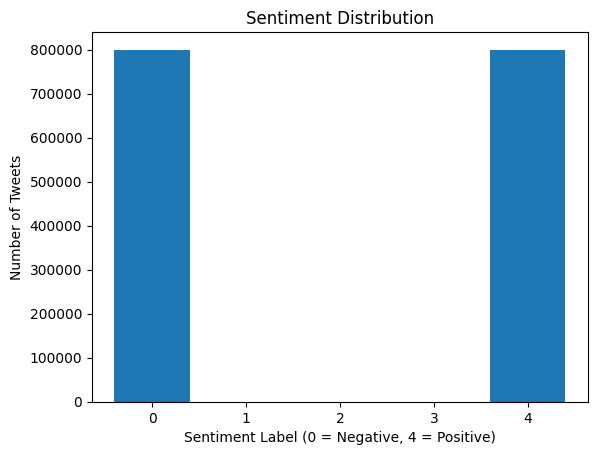

In [75]:
# Plot distribution
plt.figure()
plt.bar(sentiment_pd["sentiment"], sentiment_pd["count"])
plt.xlabel("Sentiment Label (0 = Negative, 4 = Positive)")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Distribution")
plt.show()


The labels are only 2 (postive and negative). The values are similar.

***TEXT LENGTH ANALYSIS***

In [76]:
# Adding text length column
df = df.withColumn("text_length", length(col("text")))


In [77]:
# Summary statistics
df.select("text_length").describe().show()


+-------+-----------------+
|summary|      text_length|
+-------+-----------------+
|  count|          1600000|
|   mean|     74.041770625|
| stddev|36.38799775879364|
|    min|                6|
|    max|              359|
+-------+-----------------+



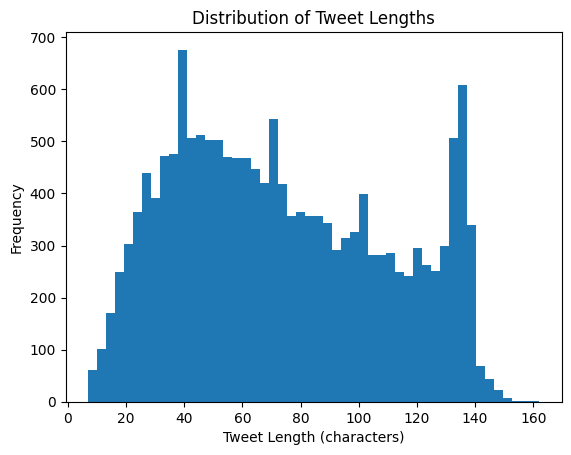

In [78]:
# Visualise distribution of text length
text_len_pd = df.select("text_length").sample(fraction=0.01).toPandas()

plt.figure()
plt.hist(text_len_pd["text_length"], bins=50)
plt.xlabel("Tweet Length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Tweet Lengths")
plt.show()


The lengths of the text varies throughout the dataset.

***TIME BASED ANALYSIS***

In [79]:
# Convert date column
df = df.withColumn(
    "timestamp",
    to_timestamp("date", "EEE MMM dd HH:mm:ss zzz yyyy")
)


In [80]:
# Tweets per day
# Set legacy time parser policy to handle Spark 3.0+ datetime parsing changes
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Tweets per day
from pyspark.sql.functions import to_date, to_timestamp, regexp_replace, col

# Removing the timezone abbreviation
df = df.withColumn("cleaned_date_str", regexp_replace(col("date"), r"\s[A-Z]{3}\s", " "))

# Then, re-parse the cleaned date string into a timestamp using a pattern without 'zzz'
# This will overwrite or effectively replace the problematic 'timestamp' column.
df = df.withColumn(
    "timestamp",
    to_timestamp(col("cleaned_date_str"), "EEE MMM dd HH:mm:ss yyyy")
)

# Calculate tweets per day
tweets_per_day = df.withColumn("day", to_date("timestamp")) \
                   .groupBy("day") \
                   .count() \
                   .orderBy("day")

tweets_per_day.show(5)

+----------+-----+
|       day|count|
+----------+-----+
|2009-04-06| 3360|
|2009-04-07|17311|
|2009-04-17| 3084|
|2009-04-18|21754|
|2009-04-19|27469|
+----------+-----+
only showing top 5 rows


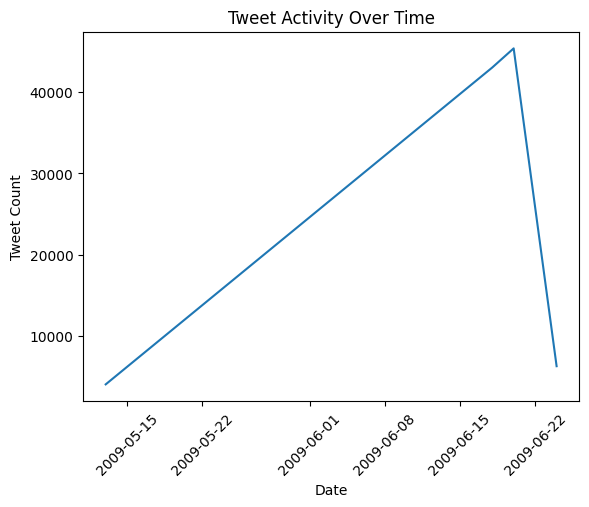

In [81]:
# Visualise tweet volume over time
tweets_day_pd = tweets_per_day.sample(fraction=0.05).toPandas()

plt.figure()
plt.plot(tweets_day_pd["day"], tweets_day_pd["count"])
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.title("Tweet Activity Over Time")
plt.xticks(rotation=45)
plt.show()


In [82]:
# Top words
from pyspark.sql.functions import explode, split, lower

words_df = df.select(
    explode(split(lower(col("text")), " ")).alias("word")
)

top_words = words_df.groupBy("word") \
    .count() \
    .orderBy(col("count").desc()) \
    .limit(20)

top_words.show(truncate=False)


+----+-------+
|word|count  |
+----+-------+
|    |1930617|
|i   |746583 |
|to  |560313 |
|the |518728 |
|a   |376421 |
|my  |312846 |
|and |295670 |
|you |237766 |
|is  |231085 |
|for |214050 |
|in  |209958 |
|it  |191050 |
|of  |182598 |
|on  |161592 |
|so  |145769 |
|have|143295 |
|that|128774 |
|me  |128489 |
|i'm |127616 |
|but |124673 |
+----+-------+



In [83]:
top_words_pd = top_words.toPandas()


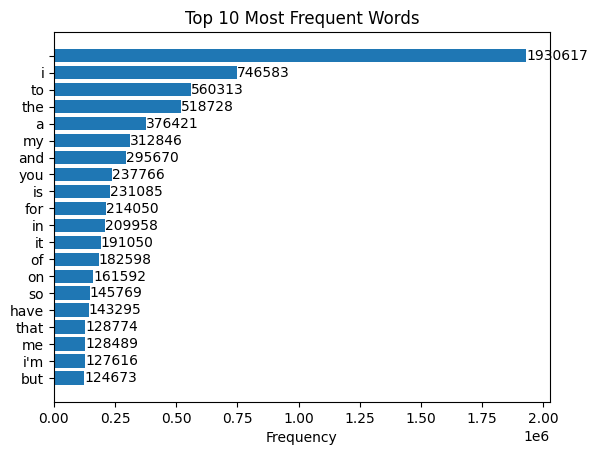

In [84]:
plt.figure()
bars = plt.barh(
    top_words_pd["word"],
    top_words_pd["count"]
)
plt.xlabel("Frequency")
plt.title("Top 10 Most Frequent Words")

for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f'{int(width)}',
        va='center'
    )

plt.gca().invert_yaxis()
plt.show()


The most frequent word is the gap (that goes between word), followed by I.


***TEXT PRE-PROCESSING***

In [85]:
# Select required columns
df_clean = df.select(
    "sentiment",
    "text",
    "timestamp"
)


In [86]:
# Get default spark stopwords
stopwords = StopWordsRemover.loadDefaultStopWords("english")


In [87]:
# Tokenise the text
from pyspark.sql.functions import explode, split, col, lower, regexp_replace

# Temporary DataFrame with the 'clean_text' column for stopword analysis
temp_df_for_stopwords = df_clean.withColumn("clean_text", lower(col("text")))
temp_df_for_stopwords = temp_df_for_stopwords.withColumn("clean_text", regexp_replace("clean_text", r"http\S+|www\S+", ""))
temp_df_for_stopwords = temp_df_for_stopwords.withColumn("clean_text", regexp_replace("clean_text", r"@\w+|#\w+", ""))
temp_df_for_stopwords = temp_df_for_stopwords.withColumn("clean_text", regexp_replace("clean_text", r"[^a-z\s]", ""))

stopword_df = temp_df_for_stopwords.select(
    explode(split(col("clean_text"), " ")).alias("word")
).filter(col("word").isin(stopwords))

In [88]:
# Count stop word frequencies
stopword_counts = stopword_df.groupBy("word") \
    .count() \
    .orderBy(col("count").desc())


In [89]:
stopword_counts.show(10)


+----+------+
|word| count|
+----+------+
|   i|751257|
|  to|564581|
| the|520085|
|   a|382776|
|  my|314117|
| and|298465|
| you|270158|
|  is|236034|
|  it|230926|
| for|215725|
+----+------+
only showing top 10 rows


In [90]:
# Convert to pandas
stopword_pd = stopword_counts.limit(200).toPandas()


In [91]:
# Install wordcloud library
!pip install wordcloud


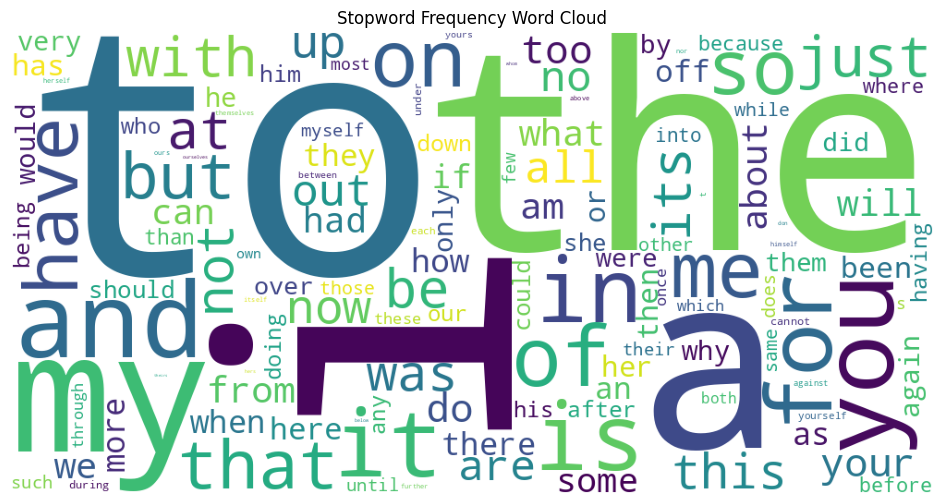

In [92]:
# Plot wordcloud
word_freq = dict(
    zip(stopword_pd["word"], stopword_pd["count"])
)

wc = WordCloud(
    width=1000,
    height=500,
    background_color="white"
).generate_from_frequencies(word_freq)

plt.figure(figsize=(14, 6))
plt.imshow(wc)
plt.axis("off")
plt.title("Stopword Frequency Word Cloud")
plt.show()


The most prominent words are: i, to, the.

***CLEAN TEXT (REMOVE NOISE)***

In [93]:
# Remove URLs, mentions, hashtags, punctuations
from pyspark.sql.functions import regexp_replace, lower, col

df_clean = df_clean.withColumn(
    "clean_text",
    lower(col("text"))
)

df_clean = df_clean.withColumn(
    "clean_text",
    regexp_replace("clean_text", r"http\S+|www\S+", "")
)

df_clean = df_clean.withColumn(
    "clean_text",
    regexp_replace("clean_text", r"@\w+|#\w+", "")
)

df_clean = df_clean.withColumn(
    "clean_text",
    regexp_replace("clean_text", r"[^a-z\s]", "")
)


In [94]:
# Tokenisation
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="clean_text",
    outputCol="tokens"
)

df_tokens = tokenizer.transform(df_clean)


In [95]:
 # Stop word removal
from pyspark.ml.feature import StopWordsRemover

stopword_remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)

df_filtered = stopword_remover.transform(df_tokens)


***FEATURE ENGINEERING***

In [96]:
# Term frequency
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(
    inputCol="filtered_tokens",
    outputCol="raw_features",
    vocabSize=10000,
    minDF=5
)

cv_model = cv.fit(df_filtered)
df_cv = cv_model.transform(df_filtered)


In [97]:
# Inverse document frequency
from pyspark.ml.feature import IDF

idf = IDF(
    inputCol="raw_features",
    outputCol="features"
)

idf_model = idf.fit(df_cv)
df_features = idf_model.transform(df_cv)


In [98]:
# Label preparation
from pyspark.sql.functions import when

df_final = df_features.withColumn(
    "label",
    when(col("sentiment") == 4, 1).otherwise(0)
)


In [99]:
# Final dataset check
df_final.select(
    "label", "features"
).show(5, truncate=False)


+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |(10000,[0,3,13,42,282,750,1090,1721,3303,9511],[1.6139158322129419,2.987120095

In [100]:
df_final.printSchema()


root
 |-- sentiment: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = false)



***MODEL EVALUATION***

In [101]:
# Train - Validation - Test split
train_df, val_df, test_df = df_final.randomSplit([0.7, 0.15, 0.15], seed=42)

print("Train:", train_df.count())
print("Validation:", val_df.count())
print("Test:", test_df.count())


Train: 1120591
Validation: 239709
Test: 239700


In [102]:
# Cache for performance optimization
train_df.cache()
val_df.cache()
test_df.cache()


DataFrame[sentiment: int, text: string, timestamp: timestamp, clean_text: string, tokens: array<string>, filtered_tokens: array<string>, raw_features: vector, features: vector, label: int]

***MODEL 1 - Logistic Regression***

In [103]:
# Train model with execution time
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=10
)

start_time = time.time()
lr_model = lr.fit(train_df)
lr_time = time.time() - start_time

print("Logistic Regression Training Time:", lr_time)


Logistic Regression Training Time: 97.79714488983154


In [104]:
# Validate model
lr_val_preds = lr_model.transform(val_df)
lr_val_preds.select("label", "prediction", "probability").show(5)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.87445708968076...|
|    0|       1.0|[0.45109832602789...|
|    0|       1.0|[0.37454118315139...|
|    0|       0.0|[0.95788234097809...|
|    0|       0.0|[0.79644220825729...|
+-----+----------+--------------------+
only showing top 5 rows


***MODEL 2 - Naive Bayes***

In [105]:
nb = NaiveBayes(
    featuresCol="features",
    labelCol="label"
)

start_time = time.time()
nb_model = nb.fit(train_df)
nb_time = time.time() - start_time

print("Naive Bayes Training Time:", nb_time)


Naive Bayes Training Time: 2.398261308670044


In [106]:
# Validate model
nb_val_preds = nb_model.transform(val_df)
nb_val_preds.select("label", "prediction", "probability").show(5)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99984766451730...|
|    0|       0.0|[0.98423479734537...|
|    0|       0.0|[0.98065934524396...|
|    0|       0.0|[0.99999999999964...|
|    0|       0.0|[0.99406909236168...|
+-----+----------+--------------------+
only showing top 5 rows


***EVALUATION METRICS (VALIDATION SET )***

In [107]:
# Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

lr_accuracy = evaluator.evaluate(lr_val_preds)
nb_accuracy = evaluator.evaluate(nb_val_preds)

print("Logistic Regression Accuracy:", lr_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)


Logistic Regression Accuracy: 0.7766166476853185
Naive Bayes Accuracy: 0.7577187339649325


In [108]:
# Precision, recall, F1
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="label"
)

lr_auc = binary_evaluator.evaluate(lr_val_preds)
nb_auc = binary_evaluator.evaluate(nb_val_preds)

print("Logistic Regression AUC:", lr_auc)
print("Naive Bayes AUC:", nb_auc)


Logistic Regression AUC: 0.8508699758818111
Naive Bayes AUC: 0.5390479792040193


***Test Set Validation***

In [109]:
lr_test_preds = lr_model.transform(test_df)
nb_test_preds = nb_model.transform(test_df)

lr_test_acc = evaluator.evaluate(lr_test_preds)
nb_test_acc = evaluator.evaluate(nb_test_preds)

print("LR Test Accuracy:", lr_test_acc)
print("NB Test Accuracy:", nb_test_acc)


LR Test Accuracy: 0.7775636211931581
NB Test Accuracy: 0.7595160617438464


***Model comparison table***

In [110]:
comparison_df = spark.createDataFrame([
    ("Logistic Regression", lr_accuracy, lr_auc, lr_time),
    ("Naive Bayes", nb_accuracy, nb_auc, nb_time)
], ["Model", "Validation Accuracy", "Validation AUC", "Training Time (sec)"])

comparison_df.show()


+-------------------+-------------------+------------------+-------------------+
|              Model|Validation Accuracy|    Validation AUC|Training Time (sec)|
+-------------------+-------------------+------------------+-------------------+
|Logistic Regression| 0.7766166476853185|0.8508699758818111|  97.79714488983154|
|        Naive Bayes| 0.7577187339649325|0.5390479792040193|  2.398261308670044|
+-------------------+-------------------+------------------+-------------------+



In [111]:
# Prepare comparison data
model_names = ["Logistic Regression", "Naive Bayes"]
accuracies = [lr_accuracy, nb_accuracy]


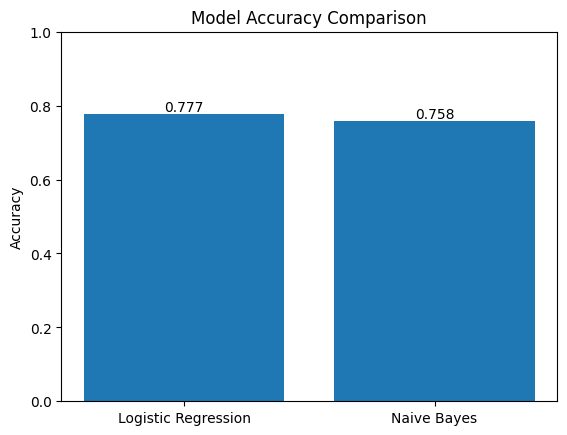

In [112]:
# Bar chart with accuracy values
plt.figure()
bars = plt.bar(model_names, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )

plt.ylim(0, 1)
plt.show()


In [113]:
# Model training time comparison
training_times = [lr_time, nb_time]


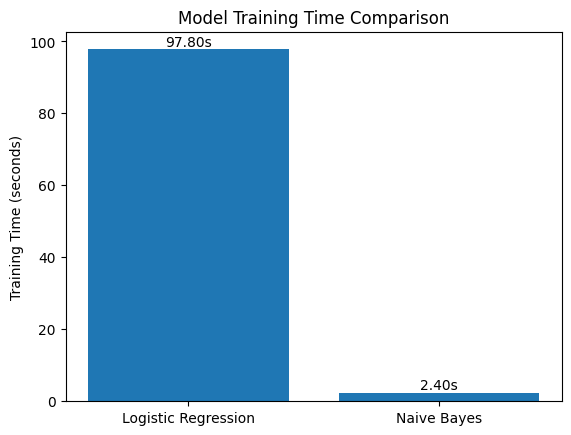

In [114]:
plt.figure()
bars = plt.bar(model_names, training_times)
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.2f}s',
        ha='center',
        va='bottom'
    )

plt.show()


***Confusion Matrix***

In [115]:
lr_sample = lr_test_preds.sample(fraction=0.01).toPandas()


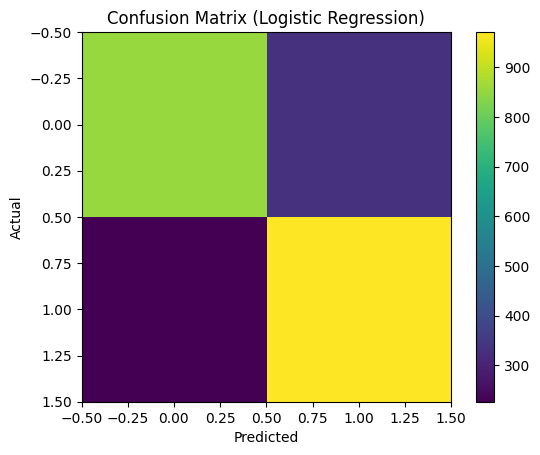

In [116]:
# Plot confusion matrix
cm = confusion_matrix(lr_sample["label"], lr_sample["prediction"])

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()


***ROC CURVE***

In [117]:
# Prepare data
lr_sample = lr_test_preds.sample(fraction=0.01).toPandas()

fpr, tpr, _ = roc_curve(
    lr_sample["label"],
    lr_sample["probability"].apply(lambda x: x[1])
)

roc_auc = auc(fpr, tpr)


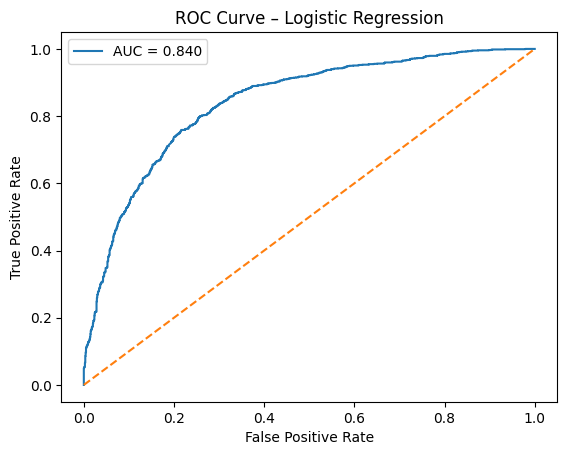

In [118]:
# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()
